图结构数据的度

In [20]:
from deeprobust.graph.data import Dataset
import pandas as pd

data = Dataset(root='./Datasets/', name='cora')

adj, features, labels = data.adj, data.features, data.labels

degrees = []

for i in range(adj.shape[0]):
    degrees.append(adj[i].nnz)

# print(degrees)
ser = pd.Series(degrees)
# ser.unique()
# ser.value_counts()

# ser.plot(kind="hist")

Loading cora dataset...
Selecting 1 largest connected components


In [36]:
print(ser.value_counts())


2      545
3      525
4      375
1      354
5      275
6      128
7       81
8       55
10      26
9       25
12      18
11      14
17       8
16       7
15       6
14       6
19       5
13       5
21       3
23       3
18       3
30       2
32       2
22       1
26       1
65       1
34       1
36       1
40       1
42       1
44       1
33       1
78       1
168      1
29       1
31       1
74       1
dtype: int64


<AxesSubplot:>

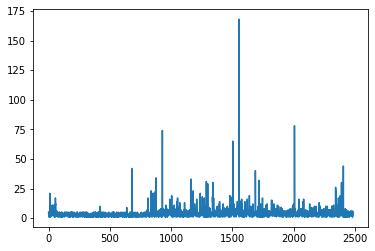

In [30]:
ser.plot.line()

<AxesSubplot:ylabel='Frequency'>

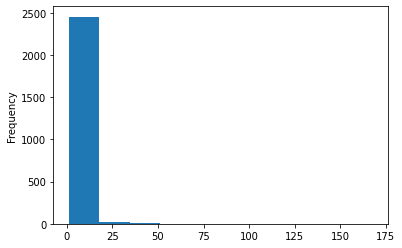

In [34]:
ser.plot.hist()